# **Training MLP Network**

# **4-1 Dataset**

In [94]:
from IPython.display import clear_output
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import mnist
import seaborn as sns
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras

In [95]:
# from keras.datasets import mnist
# objects = mnist
# (train_data, train_label),(test_data, test_label) = objects.load_data()
import gzip
import sys
import pickle
f = gzip.open('mnist.pkl.gz', 'rb')
if sys.version_info < (3,):
    objects = pickle.load(f)
else:
    objects = pickle.load(f, encoding='bytes')
f.close()
(train_data, train_label),(test_data, test_label) = objects

print("X Train data shape: ", train_data.shape)
print("Y Train data shape: ", train_label.shape)
print("X Test data shape: ", test_data.shape)
print("Y Test data shape: ", test_label.shape)


X Train data shape:  (60000, 28, 28)
Y Train data shape:  (60000,)
X Test data shape:  (10000, 28, 28)
Y Test data shape:  (10000,)


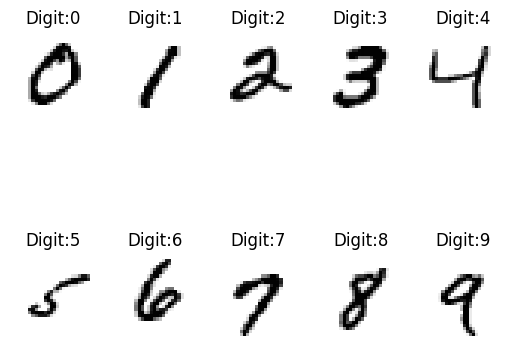

In [96]:
i = 0
j = 0
flag = 0
while i < 10:

  flag = 0
  plt.subplot(2, 5, i+1)
  
  while flag == 0:
    if train_label[j] == i:
      plt.imshow(train_data[j], cmap='gray_r')
      plt.title("Digit:{}".format(train_label[j]))
      plt.subplots_adjust(hspace=0.5)
      plt.axis('off')
      j = 0
      flag = 1
    j = j + 1
  i = i + 1



[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


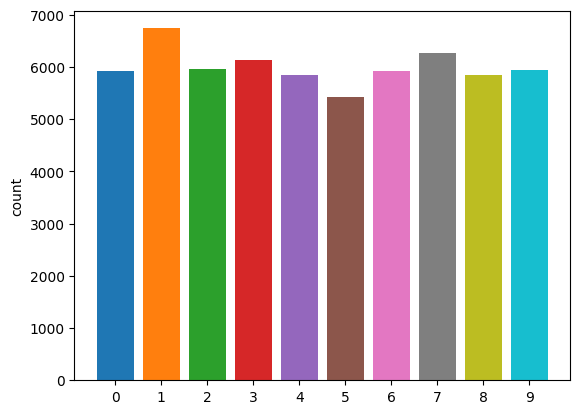

In [97]:
i = 0
j = 0
flag = 1
numOfLabs = [0] * 10
while i < 60000:
  flag = 1
  j = 0
  while j < 10 and flag:
    if train_label[i] == j:
      numOfLabs[j] = numOfLabs[j] + 1
      flag = 0
    j = j + 1
  i = i + 1

bar_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.bar(np.arange(10), numOfLabs, align='center', color=bar_colors)
plt.xticks(np.arange(10))
plt.ylabel("count")
print(numOfLabs)


In [98]:
def min_max_norm(data):
  scaled = (data - data.min()) / (data.max() - data.min())
  return scaled

test_data_norm = min_max_norm(test_data)
train_data_norm = min_max_norm(train_data)

test_label_norm = np.zeros((test_label.shape[0], 10))
i = 0
while i<test_label.shape[0]:
  test_label_norm[i][test_label[i]] =  1
  i = i + 1


train_label_norm = np.zeros((train_label.shape[0], 10))
i = 0
while i<train_label.shape[0]:
  train_label_norm[i][train_label[i]] =  1
  i = i + 1



# **4-2 Teacher Network**

In [99]:
Teacher_model=Sequential()
input_layer=Flatten(input_shape=(28,28))
Teacher_model.add(input_layer)
hidden_layer1=Dense(1024,activation='relu')
Teacher_model.add(hidden_layer1)
hidden_layer2=Dense(512,activation='relu')
Teacher_model.add(hidden_layer2)
output_layer=Dense(10,activation='linear')
Teacher_model.add(output_layer)

Teacher_model.summary()
Teacher_model.compile(optimizer =tf.keras.optimizers.SGD(learning_rate=0.01),
                      loss = tf.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_33 (Dense)            (None, 1024)              803840    
                                                                 
 dense_34 (Dense)            (None, 512)               524800    
                                                                 
 dense_35 (Dense)            (None, 10)                5130      
                                                                 
Total params: 1333770 (5.09 MB)
Trainable params: 1333770 (5.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
# updatable plot

class PlotVals(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.i += 1

        clear_output(wait=True)
        plt.subplot(2,1,1)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(self.x, self.acc, label="accuracy")
        plt.legend()
        plt.show();

plot_vals = PlotVals()

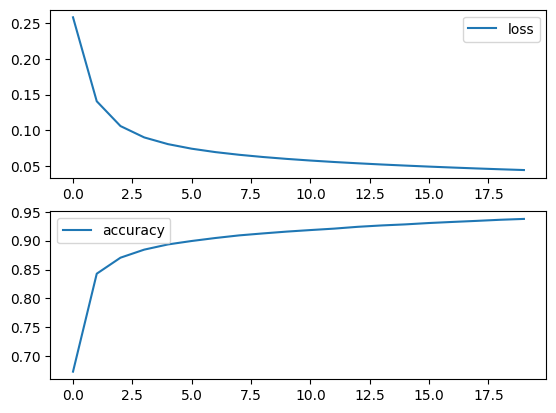

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0444 - accuracy: 0.9376


In [101]:
Teacher_model.fit(train_data_norm, train_label_norm, epochs=20, batch_size=32, callbacks=[plot_vals])

In [102]:
Teacher_model.evaluate(test_data_norm , test_label_norm)

313/313 [==============================] - 1s 2ms/step - loss: 0.0429 - accuracy: 0.9401


[0.04286154732108116, 0.9401000142097473]

In [103]:
Teacher_model_pred = Teacher_model.predict(test_data_norm)

Teacher_pred_arr = []
i = 0
mismatch = 0
while i<test_label.shape[0]:
  res = np.where(Teacher_model_pred[i] == Teacher_model_pred[i].max())
  Teacher_pred_arr.append(res[0])
  if res[0] != test_label[i]:
    mismatch = mismatch + 1
  i = i + 1

print("Number of mismatched results: ", mismatch)

313/313 [==============================] - 1s 2ms/step
Number of mismatched results:  599


# **4-3 Student Network**

In [104]:
Student_model=Sequential()
input_layer=Flatten(input_shape=(28,28))
Student_model.add(input_layer)
hidden_layer1=Dense(128,activation='relu')
Student_model.add(hidden_layer1)
hidden_layer2=Dense(64,activation='relu')
Student_model.add(hidden_layer2)
output_layer=Dense(10,activation='linear')
Student_model.add(output_layer)

Student_model.summary()
Student_model.compile(optimizer =tf.keras.optimizers.SGD(learning_rate=0.01),
                      loss = tf.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               100480    
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


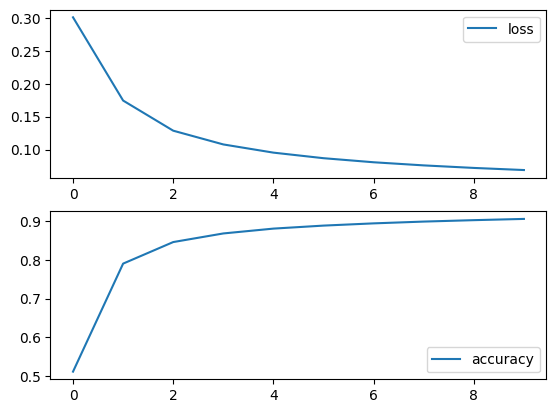

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0688 - accuracy: 0.9053


In [105]:
Student_model_history = Student_model.fit(train_data_norm, train_label_norm, epochs=10, batch_size=32, callbacks=[plot_vals])

In [106]:
Student_model.evaluate(test_data_norm , test_label_norm)

313/313 [==============================] - 0s 908us/step - loss: 0.0645 - accuracy: 0.9113


[0.06454678624868393, 0.911300003528595]

In [107]:
Student_model_pred = Student_model.predict(test_data_norm)

Student_pred_arr = []
i = 0
mismatch = 0
while i<test_label.shape[0]:
  res = np.where(Student_model_pred[i] == Student_model_pred[i].max())
  Student_pred_arr.append(res[0])
  if res[0] != test_label[i]:
    mismatch = mismatch + 1
  i = i + 1

print("Number of mismatched results: ", mismatch)

313/313 [==============================] - 0s 842us/step
Number of mismatched results:  887


# **4-4 Knowledge Distillation**

In [108]:
StudentKD_model=Sequential()
input_layer=Flatten(input_shape=(28,28))
StudentKD_model.add(input_layer)
hidden_layer1=Dense(128,activation='relu')
StudentKD_model.add(hidden_layer1)
hidden_layer2=Dense(64,activation='relu')
StudentKD_model.add(hidden_layer2)
output_layer=Dense(10,activation='linear')
StudentKD_model.add(output_layer)

StudentKD_model.summary()
StudentKD_model.compile(optimizer =tf.keras.optimizers.SGD(learning_rate=0.01),
                      loss = tf.losses.MeanSquaredError(),
                      metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dense_39 (Dense)            (None, 128)               100480    
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [109]:
train_label_logit = np.array(Teacher_model.predict(train_data_norm))

test_label_logit = np.array(Teacher_model.predict(test_data_norm))

313/313 [==============================] - 1s 2ms/step


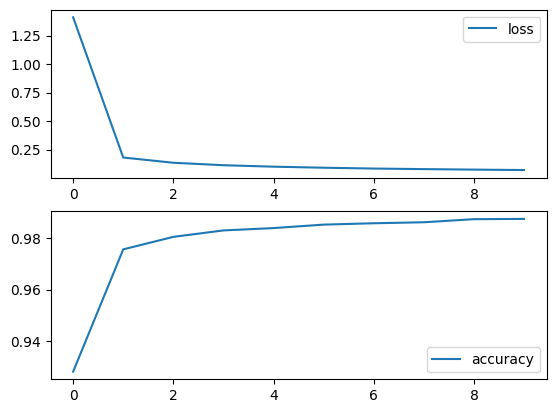

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0703 - accuracy: 0.9874


In [110]:
StudentKD_model_history = StudentKD_model.fit(train_data_norm, train_label_logit, epochs=10, batch_size=32, callbacks=[plot_vals])

In [111]:
StudentKD_model.evaluate(test_data_norm , test_label_logit)#( test_label_norm)

313/313 [==============================] - 0s 916us/step - loss: 0.0664 - accuracy: 0.9883


[0.06638237833976746, 0.9883000254631042]

In [113]:
StudentKD_model.evaluate(test_data_norm , test_label_norm)

313/313 [==============================] - 0s 912us/step - loss: 69.0790 - accuracy: 0.9348


[69.0790023803711, 0.9348000288009644]

In [114]:
StudentKD_model_pred = StudentKD_model.predict(test_data_norm)

StudentKD_pred_arr = []
i = 0
mismatch = 0
while i<test_label.shape[0]:
  res = np.where(StudentKD_model_pred[i] == StudentKD_model_pred[i].max())
  StudentKD_pred_arr.append(res[0])
  if res[0] != test_label[i]:
    mismatch = mismatch + 1
  i = i + 1

print("Number of mismatched results: ", mismatch)

313/313 [==============================] - 0s 851us/step
Number of mismatched results:  652


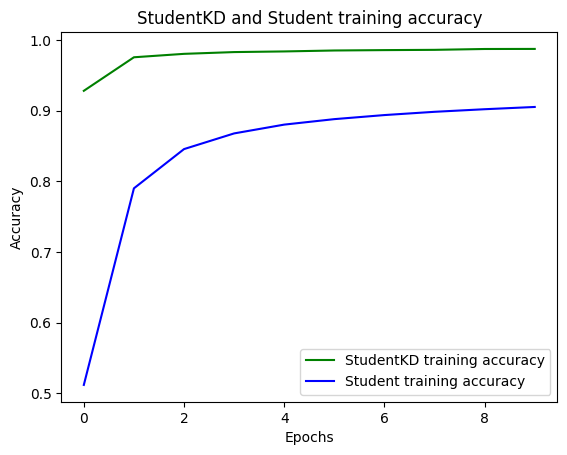

In [115]:
StudentKD_accuracy = StudentKD_model_history.history['accuracy']
Student_accuracy = Student_model_history.history['accuracy']
epochs = range(0,10)
plt.plot(epochs, StudentKD_accuracy, 'g', label='StudentKD training accuracy')
plt.plot(epochs, Student_accuracy, 'b', label='Student training accuracy')
plt.title('StudentKD and Student training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **4-4 Knowledge Distillation 2**

References: Article + https://keras.io/examples/vision/knowledge_distillation/

In [146]:
class Distiller(keras.Model):

    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):

        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [147]:
StudentKD_model2=Sequential()
input_layer=Flatten(input_shape=(28,28))
StudentKD_model2.add(input_layer)
hidden_layer1=Dense(128,activation='relu')
StudentKD_model2.add(hidden_layer1)
hidden_layer2=Dense(64,activation='relu')
StudentKD_model2.add(hidden_layer2)
output_layer=Dense(10,activation='linear')
StudentKD_model2.add(output_layer)

StudentKD_model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_54 (Dense)            (None, 128)               100480    
                                                                 


 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dense_56 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


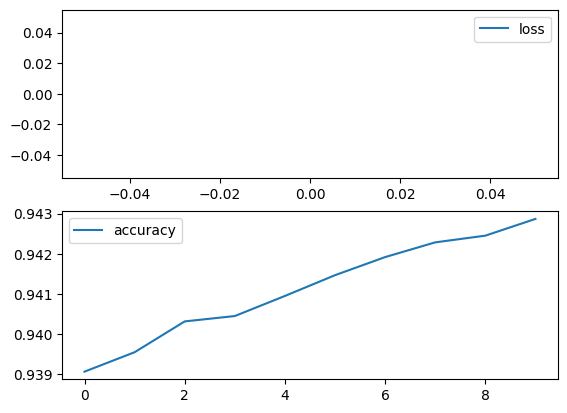

1875/1875 [==============================] - 5s 3ms/step - accuracy: 0.9429 - student_loss: 0.0191 - distillation_loss: 0.2480


In [182]:
distiller = Distiller(student=StudentKD_model2, teacher=Teacher_model)
distiller.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
    student_loss_fn=tf.losses.MeanSquaredError(),
    distillation_loss_fn=tf.losses.MeanSquaredError(),
    alpha=0.5,
    temperature=20,
)

# Distill teacher to student
StudentKD_model2_history = distiller.fit(train_data_norm, train_label_norm, epochs=10, callbacks=[plot_vals])

In [183]:
distiller.evaluate(test_data_norm , test_label_logit)#( test_label_norm)

313/313 [==============================] - 0s 919us/step - accuracy: 0.9680 - student_loss: 68.9044


[0.9679999947547913, 94.73440551757812]

In [184]:
distiller.evaluate(test_data_norm , test_label_norm)

313/313 [==============================] - 0s 885us/step - accuracy: 0.9434 - student_loss: 0.0193


[0.9434000253677368, 0.01825835555791855]

In [185]:
StudentKD_model2_pred = StudentKD_model2.predict(test_data_norm)

StudentKD_pred2_arr = []
i = 0
mismatch = 0
while i<test_label.shape[0]:
  res = np.where(StudentKD_model2_pred[i] == StudentKD_model2_pred[i].max())
  StudentKD_pred2_arr.append(res[0])
  if res[0] != test_label[i]:
    mismatch = mismatch + 1
  i = i + 1

print("Number of mismatched results: ", mismatch)

313/313 [==============================] - 0s 835us/step
Number of mismatched results:  566


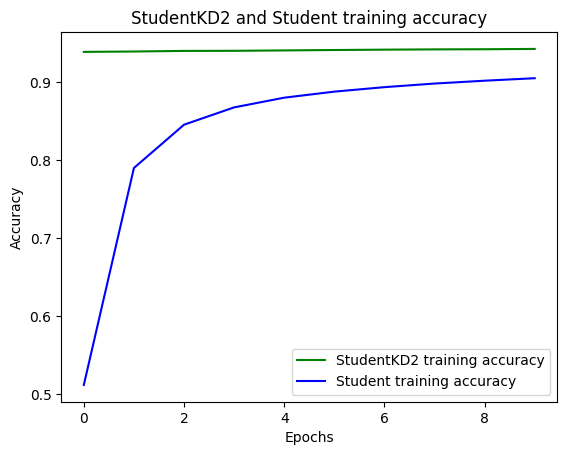

In [186]:
StudentKD2_accuracy = StudentKD_model2_history.history['accuracy']
Student_accuracy = Student_model_history.history['accuracy']
epochs = range(0,10)
plt.plot(epochs, StudentKD2_accuracy, 'g', label='StudentKD2 training accuracy')
plt.plot(epochs, Student_accuracy, 'b', label='Student training accuracy')
plt.title('StudentKD2 and Student training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()